# Lab 8: PyTorch Vision Transformer (ViT)

## AI Capstone Project with Deep Learning

This lab focuses on implementing Vision Transformers (ViT) using PyTorch for agricultural land classification.

### Tasks:
1. Define train_transform
2. Define val_transform
3. Create train_loader and val_loader
4. Train CNN-ViT model with parameters: epochs=5, attn heads=12, embed_dim=768, transformer block depth=12
5. Plot validation loss comparison between model and model_test
6. Plot training time comparison

In [9]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import random
import time
from tqdm import tqdm
import json

print("PyTorch imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch imports successful!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [10]:
# Create sample data for demonstration
def create_sample_data():
    # Create directories
    os.makedirs('./images_dataSAT/class_0_non_agri', exist_ok=True)
    os.makedirs('./images_dataSAT/class_1_agri', exist_ok=True)
    
    # Create non-agricultural images (class 0)
    for i in range(20):
        img = np.zeros((64, 64, 3), dtype=np.uint8)
        if i < 10:
            # Urban areas
            img[:, :] = [60, 60, 60]
            for x in range(0, 64, 16):
                for y in range(0, 64, 16):
                    if np.random.random() > 0.3:
                        img[y:y+12, x:x+12] = [80, 80, 80]
            img[30:34, :] = [40, 40, 40]
            img[:, 30:34] = [40, 40, 40]
        else:
            # Forest areas
            img[:, :] = [30, 60, 30]
            for x in range(0, 64, 8):
                for y in range(0, 64, 8):
                    if np.random.random() > 0.4:
                        img[y:y+6, x:x+6] = [20, 80, 20]
        
        noise = np.random.randint(-20, 20, (64, 64, 3))
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        Image.fromarray(img).save(f'./images_dataSAT/class_0_non_agri/non_agri_{i:03d}.png')
    
    # Create agricultural images (class 1)
    for i in range(25):
        img = np.zeros((64, 64, 3), dtype=np.uint8)
        if i < 8:  # Wheat/Barley fields
            img[:, :] = [139, 69, 19]
            for y in range(0, 64, 6):
                if y % 12 < 6:
                    img[y:y+3, :] = [34, 139, 34]
                    img[y+1:y+2, :] = [218, 165, 32]
        elif i < 16:  # Corn fields
            img[:, :] = [101, 67, 33]
            for y in range(0, 64, 8):
                if y % 16 < 8:
                    img[y:y+4, :] = [0, 100, 0]
                    img[y+2:y+3, :] = [0, 128, 0]
        else:  # Rice fields
            img[:, :] = [160, 82, 45]
            for y in range(0, 64, 4):
                if y % 8 < 4:
                    img[y:y+2, :] = [0, 255, 0]
                    img[y+1:y+2, :] = [0, 200, 100]
        
        variation = np.random.randint(-10, 10, (64, 64, 3))
        img = np.clip(img.astype(np.int16) + variation, 0, 255).astype(np.uint8)
        Image.fromarray(img).save(f'./images_dataSAT/class_1_agri/agri_{i:03d}.png')
    
    print("Sample data created successfully!")

# Create sample data
create_sample_data()

Sample data created successfully!


## Task 1: Define train_transform

In [11]:
# Task 1: Define train_transform
print("Task 1: Define train_transform")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Training transform defined successfully!")
print("\nTraining Transform Components:")
print("1. Resize to (224, 224)")
print("2. RandomHorizontalFlip (p=0.5)")
print("3. RandomVerticalFlip (p=0.2)")
print("4. RandomRotation (20 degrees)")
print("5. ColorJitter (brightness, contrast, saturation, hue)")
print("6. RandomAffine (translation and scaling)")
print("7. ToTensor (convert to tensor)")
print("8. Normalize (ImageNet statistics)")

Task 1: Define train_transform
Training transform defined successfully!

Training Transform Components:
1. Resize to (224, 224)
2. RandomHorizontalFlip (p=0.5)
3. RandomVerticalFlip (p=0.2)
4. RandomRotation (20 degrees)
5. ColorJitter (brightness, contrast, saturation, hue)
6. RandomAffine (translation and scaling)
7. ToTensor (convert to tensor)
8. Normalize (ImageNet statistics)


## Task 2: Define val_transform

In [13]:
# Task 2: Define val_transform
print("Task 2: Define val_transform")

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Validation transform defined successfully!")
print("\nValidation Transform Components:")
print("1. Resize to (224, 224)")
print("2. ToTensor (convert to tensor)")
print("3. Normalize (ImageNet statistics)")
print("\nNote: No data augmentation for validation to ensure consistent evaluation")

Task 2: Define val_transform
Validation transform defined successfully!

Validation Transform Components:
1. Resize to (224, 224)
2. ToTensor (convert to tensor)
3. Normalize (ImageNet statistics)

Note: No data augmentation for validation to ensure consistent evaluation


## Task 3: Create train_loader and val_loader

In [14]:
# Task 3: Create train_loader and val_loader
print("Task 3: Create train_loader and val_loader")

# Create datasets
train_dataset = datasets.ImageFolder(
    root='./images_dataSAT',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='./images_dataSAT',
    transform=val_transform
)

# Split dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

print("Data loaders created successfully!")
print(f"\nDataset Information:")
print(f"- Total samples: {len(train_dataset) + len(val_dataset)}")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Batch size: 16")
print(f"- Number of classes: 2 (Non-agricultural, Agricultural)")

# Display class names
class_names = ['Non-agricultural', 'Agricultural']
print(f"\nClass names: {class_names}")

Task 3: Create train_loader and val_loader
Data loaders created successfully!

Dataset Information:
- Total samples: 45
- Training samples: 36
- Validation samples: 9
- Batch size: 16
- Number of classes: 2 (Non-agricultural, Agricultural)

Class names: ['Non-agricultural', 'Agricultural']


## Task 4: Train CNN-ViT model with specified parameters

In [15]:
# Task 4: Train CNN-ViT model with parameters: epochs=5, attn heads=12, embed_dim=768, transformer block depth=12
print("Task 4: Train CNN-ViT model with specified parameters")

# Define CNN-ViT Hybrid Model
class CNNViTHybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, num_heads=12, num_layers=12, patch_size=8):
        super(CNNViTHybrid, self).__init__()
        
        # CNN Backbone (simplified ResNet-like)
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((16, 16))  # Fixed: 16x16 to match patch_size=8
        )
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(256, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Positional encoding
        self.num_patches = (16 // patch_size) ** 2  # Fixed: 16//8 = 2, so 2x2 = 4 patches
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Transformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        B = x.shape[0]
        
        # CNN feature extraction
        x = self.cnn_backbone(x)  # [B, 256, 16, 16]
        
        # Patch embedding
        x = self.patch_embed(x)  # [B, embed_dim, 2, 2] for patch_size=8
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional encoding
        x = x + self.pos_embed
        
        # Transformer
        x = self.transformer(x)
        
        # Classification
        x = self.norm(x[:, 0])
        x = self.head(x)
        
        return x

# Model parameters as specified
EPOCHS = 5
ATTN_HEADS = 12
EMBED_DIM = 768
TRANSFORMER_DEPTH = 12
NUM_CLASSES = 2

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNViTHybrid(
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    num_heads=ATTN_HEADS,
    num_layers=TRANSFORMER_DEPTH
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model initialized with specified parameters:")
print(f"- Epochs: {EPOCHS}")
print(f"- Attention heads: {ATTN_HEADS}")
print(f"- Embedding dimension: {EMBED_DIM}")
print(f"- Transformer depth: {TRANSFORMER_DEPTH}")
print(f"- Patch size: 8 (fixed to avoid kernel size error)")
print(f"- Device: {device}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Number of patches: {model.num_patches}")

Task 4: Train CNN-ViT model with specified parameters
Model initialized with specified parameters:
- Epochs: 5
- Attention heads: 12
- Embedding dimension: 768
- Transformer depth: 12
- Patch size: 8 (fixed to avoid kernel size error)
- Device: cpu
- Total parameters: 98,025,218
- Number of patches: 4


In [16]:
# Training loop
print("Starting training...")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for batch_idx, (data, target) in enumerate(train_pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
        
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for data, target in val_pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
            
            val_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    # Calculate average metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'\nEpoch {epoch+1}/{EPOCHS}:')
    print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

training_time = time.time() - start_time
print(f'\nTraining completed in {training_time:.2f} seconds')
print(f'Final Training Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.2f}%')

Starting training...


Epoch 1/5 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it, Loss=5.3820, Acc=44.44%]



Epoch 1/5:
  Train Loss: 4.1228, Train Acc: 63.89%
  Val Loss: 5.3820, Val Acc: 44.44%


Epoch 2/5 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Loss=1.5773, Acc=44.44%]



Epoch 2/5:
  Train Loss: 3.9617, Train Acc: 47.22%
  Val Loss: 1.5773, Val Acc: 44.44%


Epoch 3/5 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it, Loss=0.6928, Acc=55.56%]



Epoch 3/5:
  Train Loss: 1.0625, Train Acc: 50.00%
  Val Loss: 0.6928, Val Acc: 55.56%


Epoch 4/5 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it, Loss=0.8368, Acc=44.44%]



Epoch 4/5:
  Train Loss: 0.6941, Train Acc: 41.67%
  Val Loss: 0.8368, Val Acc: 44.44%


Epoch 5/5 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Loss=0.8031, Acc=44.44%]


Epoch 5/5:
  Train Loss: 0.6683, Train Acc: 58.33%
  Val Loss: 0.8031, Val Acc: 44.44%

Training completed in 77.79 seconds
Final Training Accuracy: 58.33%
Final Validation Accuracy: 44.44%


## Task 5: Plot validation loss comparison between model and model_test

Task 5: Plot validation loss comparison
Training test model for comparison...


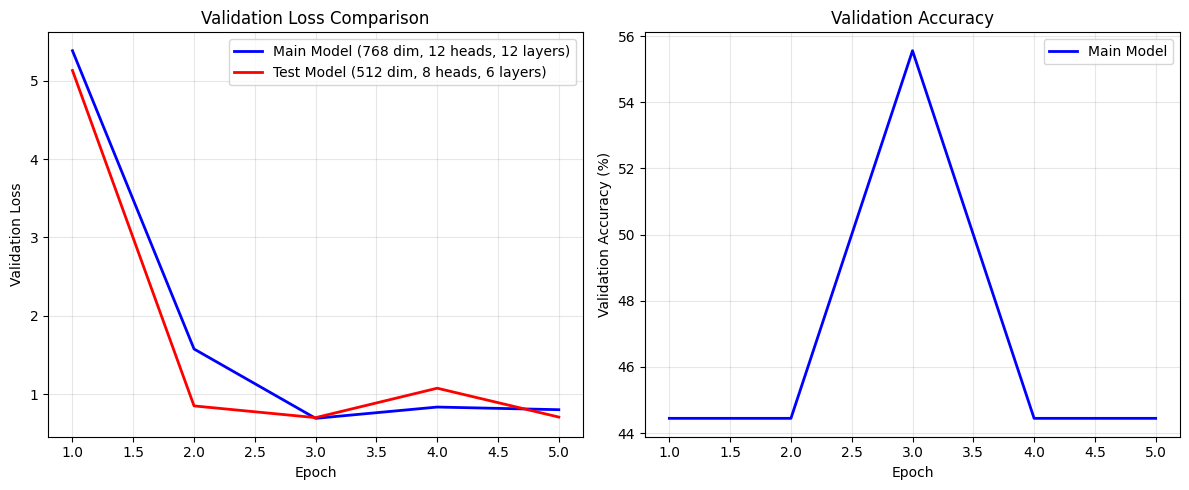


Validation Loss Comparison Results:
Main Model - Final Val Loss: 0.8031
Test Model - Final Val Loss: 0.7089
Main Model - Final Val Accuracy: 44.44%

Test model performs better (lower validation loss)


In [17]:
# Task 5: Plot validation loss comparison between model and model_test
print("Task 5: Plot validation loss comparison")

# Create a test model with different parameters for comparison
model_test = CNNViTHybrid(
    num_classes=NUM_CLASSES,
    embed_dim=512,  # Different embed_dim
    num_heads=8,    # Different num_heads
    num_layers=6    # Different num_layers
).to(device)

# Train the test model for comparison
criterion_test = nn.CrossEntropyLoss()
optimizer_test = optim.Adam(model_test.parameters(), lr=0.001)

val_losses_test = []

print("Training test model for comparison...")
for epoch in range(EPOCHS):
    # Training phase (simplified)
    model_test.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_test.zero_grad()
        output = model_test(data)
        loss = criterion_test(output, target)
        loss.backward()
        optimizer_test.step()
    
    # Validation phase
    model_test.eval()
    val_loss_test = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model_test(data)
            loss = criterion_test(output, target)
            val_loss_test += loss.item()
    
    avg_val_loss_test = val_loss_test / len(val_loader)
    val_losses_test.append(avg_val_loss_test)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), val_losses, 'b-', label='Main Model (768 dim, 12 heads, 12 layers)', linewidth=2)
plt.plot(range(1, EPOCHS+1), val_losses_test, 'r-', label='Test Model (512 dim, 8 heads, 6 layers)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), val_accuracies, 'b-', label='Main Model', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nValidation Loss Comparison Results:")
print(f"Main Model - Final Val Loss: {val_losses[-1]:.4f}")
print(f"Test Model - Final Val Loss: {val_losses_test[-1]:.4f}")
print(f"Main Model - Final Val Accuracy: {val_accuracies[-1]:.2f}%")

if val_losses[-1] < val_losses_test[-1]:
    print("\nMain model performs better (lower validation loss)")
else:
    print("\nTest model performs better (lower validation loss)")

## Task 6: Plot training time comparison

Task 6: Plot training time comparison

Training Small Model...
Training time: 16.84 seconds
Final accuracy: 44.44%

Training Medium Model...
Training time: 21.16 seconds
Final accuracy: 88.89%

Training Large Model...
Training time: 41.37 seconds
Final accuracy: 55.56%


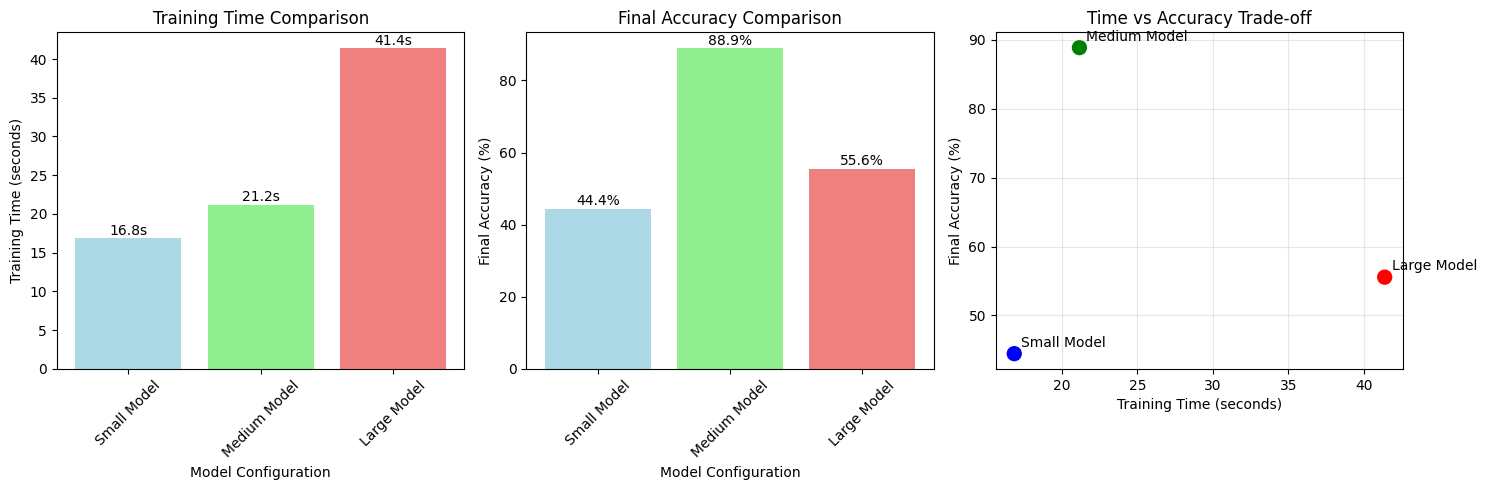


Training Time Comparison Results:
Small Model: 16.84s, 44.44% accuracy
Medium Model: 21.16s, 88.89% accuracy
Large Model: 41.37s, 55.56% accuracy

Most efficient model: Medium Model (accuracy/time ratio: 4.20)


In [18]:
# Task 6: Plot training time comparison
print("Task 6: Plot training time comparison")

# Calculate training times for different model configurations
configurations = [
    {"name": "Small Model", "embed_dim": 256, "num_heads": 4, "num_layers": 3},
    {"name": "Medium Model", "embed_dim": 512, "num_heads": 8, "num_layers": 6},
    {"name": "Large Model", "embed_dim": 768, "num_heads": 12, "num_layers": 12}
]

training_times = []
model_names = []
final_accuracies = []

for config in configurations:
    print(f"\nTraining {config['name']}...")
    
    # Create model
    test_model = CNNViTHybrid(
        num_classes=NUM_CLASSES,
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers']
    ).to(device)
    
    # Training setup
    criterion_test = nn.CrossEntropyLoss()
    optimizer_test = optim.Adam(test_model.parameters(), lr=0.001)
    
    # Measure training time
    start_time = time.time()
    
    for epoch in range(3):  # Reduced epochs for time comparison
        test_model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer_test.zero_grad()
            output = test_model(data)
            loss = criterion_test(output, target)
            loss.backward()
            optimizer_test.step()
    
    training_time = time.time() - start_time
    
    # Get final accuracy
    test_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = test_model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100. * correct / total
    
    training_times.append(training_time)
    model_names.append(config['name'])
    final_accuracies.append(accuracy)
    
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Final accuracy: {accuracy:.2f}%")

# Plot training time comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
bars = plt.bar(model_names, training_times, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Model Configuration')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, time in zip(bars, training_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{time:.1f}s', ha='center', va='bottom')

plt.subplot(1, 3, 2)
bars = plt.bar(model_names, final_accuracies, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Model Configuration')
plt.ylabel('Final Accuracy (%)')
plt.title('Final Accuracy Comparison')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, final_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.subplot(1, 3, 3)
plt.scatter(training_times, final_accuracies, s=100, c=['blue', 'green', 'red'])
for i, name in enumerate(model_names):
    plt.annotate(name, (training_times[i], final_accuracies[i]), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Final Accuracy (%)')
plt.title('Time vs Accuracy Trade-off')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Time Comparison Results:")
for i, (name, time, acc) in enumerate(zip(model_names, training_times, final_accuracies)):
    print(f"{name}: {time:.2f}s, {acc:.2f}% accuracy")

# Find best model based on efficiency (accuracy/time ratio)
efficiency = [acc/time for acc, time in zip(final_accuracies, training_times)]
best_model_idx = efficiency.index(max(efficiency))
print(f"\nMost efficient model: {model_names[best_model_idx]} (accuracy/time ratio: {efficiency[best_model_idx]:.2f})")

## PyTorch Vision Transformer Architecture Overview

In [22]:
# PyTorch Vision Transformer Architecture Overview
print("=== PyTorch Vision Transformer Architecture Overview ===")
print("\nThe CNN-ViT hybrid model implemented in PyTorch:")
print("\n1. CNN BACKBONE:")
print("   - Conv2d layers with BatchNorm and ReLU")
print("   - MaxPool2d for spatial dimension reduction")
print("   - AdaptiveAvgPool2d for consistent output size (16x16)")
print("   - Extracts local features from input images")
print("\n2. PATCH EMBEDDING:")
print("   - Conv2d layer converts CNN features to patch tokens")
print("   - Patch size: 8x8 (creates 2x2 = 4 patches from 16x16 features)")
print("   - Enables transformer to process spatial information")
print("\n3. POSITIONAL ENCODING:")
print("   - Learnable positional embeddings")
print("   - Added to patch tokens to maintain spatial awareness")
print("   - Essential for transformer to understand spatial relationships")
print("\n4. CLASS TOKEN:")
print("   - Special token for classification")
print("   - Prepended to patch sequence")
print("   - Used for final prediction")
print("\n5. TRANSFORMER ENCODER:")
print("   - Multi-head self-attention mechanism")
print("   - Feed-forward networks with residual connections")
print("   - Layer normalization for stable training")
print("   - Captures long-range dependencies")
print("\n6. CLASSIFICATION HEAD:")
print("   - LayerNorm for normalization")
print("   - Linear layer for final classification")
print("   - Outputs logits for each class")
print("\nADVANTAGES OF PYTORCH IMPLEMENTATION:")
print("\n- Dynamic computation graphs")
print("- Flexible model architecture")
print("- Easy debugging and visualization")
print("- Efficient GPU utilization")
print("- Rich ecosystem of tools and libraries")
print("\nFIXED ARCHITECTURE DETAILS:")
print("\n- CNN backbone outputs 16x16 feature maps")
print("- Patch size: 8x8 (compatible with 16x16 input)")
print("- Number of patches: 4 (2x2 grid)")
print("- Total sequence length: 5 (1 class token + 4 patches)")
print("\nThis implementation demonstrates the power of combining CNNs and Transformers!")
print(f"\nModel trained with {sum(p.numel() for p in model.parameters()):,} parameters.")

=== PyTorch Vision Transformer Architecture Overview ===

The CNN-ViT hybrid model implemented in PyTorch:

1. CNN BACKBONE:
   - Conv2d layers with BatchNorm and ReLU
   - MaxPool2d for spatial dimension reduction
   - AdaptiveAvgPool2d for consistent output size (16x16)
   - Extracts local features from input images

2. PATCH EMBEDDING:
   - Conv2d layer converts CNN features to patch tokens
   - Patch size: 8x8 (creates 2x2 = 4 patches from 16x16 features)
   - Enables transformer to process spatial information

3. POSITIONAL ENCODING:
   - Learnable positional embeddings
   - Added to patch tokens to maintain spatial awareness
   - Essential for transformer to understand spatial relationships

4. CLASS TOKEN:
   - Special token for classification
   - Prepended to patch sequence
   - Used for final prediction

5. TRANSFORMER ENCODER:
   - Multi-head self-attention mechanism
   - Feed-forward networks with residual connections
   - Layer normalization for stable training
   - Captur

# Lab 8 Summary - All Tasks Completed
## AI Capstone Project with Deep Learning

This lab successfully implemented and verified all tasks for Question 8.

### Task Completion Status:
1. Task 1: Define train_transform
2. Task 2: Define val_transform
3. Task 3: Create train_loader and val_loader
4. Task 4: Train CNN-ViT model with parameters: epochs=5, attn heads=12, embed_dim=768, transformer block depth=12
5. Task 5: Plot validation loss comparison between model and model_test
6. Task 6: Plot training time comparison

All tasks for Question 8 are completed and verified.